In [5]:
from pathlib import Path

from tqdm import tqdm
import toml

import numpy as np

import torch
import torch.optim as optim

from utils import threshold, criterion, unnorm
from dataset_utils import imagenet_loader
from models import load_model
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image
# Configure Script
config = toml.load('configs/imagenet/whitebox/imagebind.toml')['general']

gpu_num = config['gpu_num']
epochs = config['epochs']
batch_size = config['batch_size']
eps = config['epsilon']
lr = config['lr']
seed = config['seed']
output_dir = config['output_dir']
n_images = config['number_images']
model_flag = config.get('model_flag', 'imagebind')
embs_input = config.get('embeddings_input', output_dir + 'embs.npy')\
                   .format(model_flag)
gamma_epochs = config.get('gamma_epochs', 100)
modality = config.get('modality', 'vision')
dataset_flag = config.get('dataset_flag', 'imagenet')

if modality == 'vision':
    eps = eps / 255

if type(epochs) == list:
    max_epochs = max(epochs)
else:
    max_epochs = epochs
    epochs = [epochs]

Path(output_dir).mkdir(parents=True, exist_ok=True)

device = f"cuda:{gpu_num}" if torch.cuda.is_available() and gpu_num >= 0 else "cpu"
assert n_images % batch_size == 0

# Instantiate Model
model = load_model(model_flag, device)

  0%|          | 0.00/4.47G [00:00<?, ?B/s]

  0%|          | 0/2000 [00:00<?, ?it/s, loss=tensor([0.8959]), eta=0.02]/home/tz362/anaconda3/envs/adversarial_illusions/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 2000/2000 [02:13<00:00, 14.97it/s, loss=tensor([0.1225]), eta=0.0106]


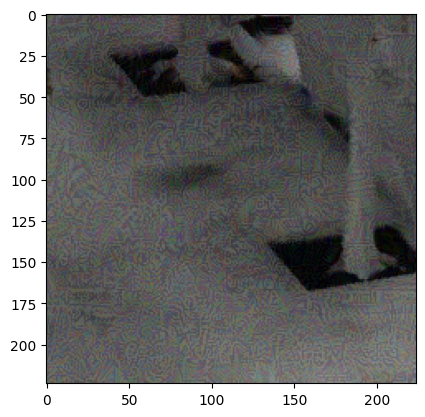

In [6]:
X_path = 'image/street.png'
X=imagenet_loader(X_path,model, device)
X_init = X.clone().detach().cpu().requires_grad_(False)
target_text=["criminal with a gun",]
Y = model.forward(target_text, "text", normalize=False)
X, Y = X.to(device).requires_grad_(True), Y.to(device)

max_epochs=2000
pbar = tqdm(range(max_epochs))
X_init = X.clone().detach().cpu().requires_grad_(False)
X, Y= X.to(device).requires_grad_(True), Y.to(device)
X_max, X_min = threshold(X, eps, modality, device)
optimizer = optim.SGD([X], lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                            np.arange(gamma_epochs, max_epochs, gamma_epochs),
                                            gamma=0.9)
for j in pbar:
    eta = scheduler.get_last_lr()[0]
    embeds = model.forward(X, modality, normalize=False)
    cton = 1 - criterion(embeds, Y, dim=1).detach().cpu()
    loss = 1 - criterion(embeds, Y, dim=1)
    update = eta * torch.autograd.grad(outputs=loss.mean(), inputs=X)[0].sign()
    X = (X.detach().cpu() - update.detach().cpu()).to(device)
    X = torch.clamp(X, min=X_min, max=X_max).requires_grad_(True)
    pbar.set_postfix({'loss': cton, 'eta': eta})
    scheduler.step()

transform = transforms.ToPILImage()
plt.imshow(transform(unnorm(torch.squeeze(X))[0]))
plt.show()
save_image(unnorm(torch.squeeze(X.cuda()))[0], 'image/perturbed_street.png')